In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import norm
import copy

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from model import Symmetric, DeepSets, KNN, KK
from sample import generate_data, generate_narrow_data
from train import train
from evaluate import generalization_error, cross_validate

%matplotlib inline

In [2]:
#For smooth neuron experiment, it's only fair to S2 if the neuron is drawn from the same random features

def smooth_neuron_weight_init(model, objective):
    if objective.__name__ == "smooth_neuron":
        if model.__name__ == "S2" or model.__name__ == "S3":
            with torch.no_grad():
                m = objective.__network__.phi.fc.weight.shape[0]
                model.phi.fc.weight[:m] = objective.__network__.phi.fc.weight
                model.phi.fc.weight.div_(torch.norm(model.phi.fc.weight, dim = 1, keepdim = True))

In [4]:
def compare_models(N_max, hidden_dim, iterations, batch_size, input_dim, objective, narrow, 
                   verbose = True, log_plot = False, scaleup = False, kernel_buff = False, squared = False):
    
    print("currently", objective.__name__)
    
    bias_first = "neuron" in objective.__name__

    c = 1 if not scaleup else 2
    
    k = 10 if kernel_buff else 1

    f1 = Symmetric(input_dim, c * hidden_dim, hidden_dim, squared = squared)
    f2 = KNN(input_dim, c * k * hidden_dim, hidden_dim, squared = squared)
    f3 = KK(input_dim, c * k * hidden_dim, k * hidden_dim, squared = squared)

    f1.__name__ = "S1"
    f2.__name__ = "S2"
    f3.__name__ = "S3"

    models = [f1, f2, f3]
    lambs = [0., 1e-6, 1e-4, 1e-2]
    N_list = np.arange(2, N_max + 16)

    for model in models:
        x, y = generate_data(N_max, batch_size, input_dim, objective, narrow, bias_first)
        
        smooth_neuron_weight_init(model, objective)
        
        cv_models = cross_validate(model, x, y, iterations, lambs, verbose)
        
        validation_errors = np.zeros_like(lambs)
        for i, cv_model in enumerate(cv_models):
            validation_errors[i] = generalization_error([N_max], 1000, input_dim, cv_model,
                                                        objective, narrow, bias_first)[0]
        
        i = np.argmin(validation_errors)
        lamb = lambs[i]
            
        runs = 10
        run_errors = np.zeros((runs, len(N_list)))
        for i in range(runs):
            x, y = generate_data(N_max, batch_size, input_dim, objective, narrow, bias_first)
            model_copy = copy.deepcopy(model)
            model_copy.reinit()
            smooth_neuron_weight_init(model_copy, objective)
            
            train(model_copy, x, y, iterations, lamb)
            errors = generalization_error(N_list, 1000, input_dim, model_copy, objective, narrow, bias_first)
            run_errors[i] = np.array(errors)
        
        mean_error = np.mean(run_errors, axis = 0)
        std_error = np.std(run_errors, axis = 0)
        if verbose:
            print("performance of ", model.__name__, " on ", objective.__name__)
            print("lamb =", lamb)
            print(mean_error)
            print(std_error)
            
            
        narrow_str = "Narrow" if narrow else "Wide"
        scaleup_str = "scaleup" if scaleup else ""
        save_str = model.__name__ + "_" + objective.__name__ + "_" + narrow_str + "_" + str(input_dim)
        save_str += "_" + str(scaleup) + "_" + str(kernel_buff) + "_" + str(squared)
        save_dir = "saved_data_2022/"
            
        np.save(save_dir + save_str + "_mean", mean_error)
        np.save(save_dir + save_str + "_std", std_error)
        
        if log_plot:
            plt.semilogy(N_list, mean_error, label = model.__name__)
        else:
            plt.plot(N_list, mean_error, label = model.__name__)
        plt.fill_between(N_list, mean_error - std_error, mean_error + std_error, alpha = 0.2)

    
    plt.legend()
    plt.ylim([1e-5, 1e2]) 

    plt.xlabel("N")
    plt.ylabel("Mean Square Error")
    narrow_str = "Narrow" if narrow else "Wide"
    plt.title(narrow_str + " generalization for " + objective.__name__)
    scaleup_str = "scaleup" if scaleup else ""
#     plt.savefig("plots_high_dim/" + objective.__name__ + "_" + narrow_str + "_" + str(input_dim) + scaleup_str)
    plt.show()
    plt.close()

In [5]:
#For the rest of the notebook
#input_dim = 20
input_dim = 10
hidden_dim = 100
squared = True

In [6]:
mean = lambda x: np.mean(norm(x, axis = 2), axis = 1, keepdims = True)

median = lambda x: np.median(norm(x, axis = 2), axis = 1, keepdims = True)

maximum = lambda x: np.max(norm(x, axis = 2), axis = 1, keepdims = True)

lamb = 0.1
softmax = lambda x: lamb * np.log(np.mean(np.exp(norm(x, axis = 2) / lamb), axis = 1, keepdims = True))

second = lambda x: np.sort(norm(x, axis = 2), axis = 1)[:,-2].reshape(-1,1)

In [7]:
meanquant = lambda x: np.mean(np.quantile(x, 0.7, axis = 2), axis = 1, keepdims = True)

medianquant = lambda x: np.median(np.quantile(x, 0.7, axis = 2), axis = 1, keepdims = True)

maximumquant = lambda x: np.max(np.quantile(x, 0.7, axis = 2), axis = 1, keepdims = True)

lamb = 0.1
softmaxquant = lambda x: lamb * np.log(np.mean(np.exp(np.quantile(x, 0.7, axis = 2) / lamb), axis = 1, keepdims = True))

secondquant = lambda x: np.sort(np.quantile(x, 0.7, axis = 2), axis = 1)[:,-2].reshape(-1,1)

In [8]:
from scipy.spatial import distance_matrix

def potential(x):
    energies = np.zeros((x.shape[0], 1))
    for i in range(x.shape[0]):

        r = x[i]
        D = distance_matrix(r, r)

        np.fill_diagonal(D, 1)
        D = 1.0/D
        
        m = D.shape[0]
        r,c = np.triu_indices(m,1)
        D = D[r,c]
        energies[i] = -np.mean(D)
        
    return energies

In [9]:
def mixture(tensor, mean_1, std_1, mean_2, std_2):
    with torch.no_grad():
        x_1 = mean_1 + std_1 * torch.randn_like(tensor)
        x_2 = mean_2 + std_2 * torch.randn_like(tensor)
        
        p = torch.bernoulli(torch.zeros_like(tensor) + 0.5)
        tensor.data = p * x_1 + (1-p) * x_2


In [10]:
### May need to sample several neurons to find one that isn't degenerate on the domain

torch.manual_seed(50)
np.random.seed(50)

teacher = Symmetric(input_dim, 1, 1, squared = squared)
# torch.nn.init.uniform_(teacher.phi.fc.weight, a = -5.0, b = 2.0)
mixture(teacher.phi.fc.weight, 1.0, 0.5, -1.0, 0.5)
teacher.eval()

def neuron(x):
    x = torch.from_numpy(x).float()
    y = teacher(x)
    return y.data.numpy().reshape(-1, 1)

neuron.__network__ = teacher

x, y = generate_narrow_data(3, 15, input_dim, neuron, bias_first = True)
print(y.data.numpy().flatten())

[-2.9413853  -0.9735007   0.         -0.6611508  -0.17372644 -0.10888965
 -3.002563   -0.89388555 -1.2175204  -3.8266776  -0.3530697  -2.9725735
 -0.36615312 -1.504894   -0.9650178 ]


In [11]:
### May need to sample several neurons to find one that isn't degenerate on the domain

smooth_teacher = Symmetric(input_dim, hidden_dim, 1, squared = squared)
# torch.nn.init.uniform_(smooth_teacher.rho.fc1.weight,a = -0.3, b = 0.3)
mixture(teacher.rho.fc1.weight, 1.0, 0.5, -1.0, 0.5)
smooth_teacher.eval()

def smooth_neuron(x):
    x = torch.from_numpy(x).float()
    y = smooth_teacher(x)
    return y.data.numpy().reshape(-1, 1)

smooth_neuron.__network__ = smooth_teacher

x, y = generate_narrow_data(3, 15, input_dim, smooth_neuron, bias_first = True)
print(y.data.numpy().flatten())

[-0.02960487  0.          0.         -0.02094294 -0.03513904 -0.02753521
 -0.02093345 -0.00561744  0.         -0.03878238 -0.00878886 -0.00971054
 -0.00958526 -0.0464745  -0.00434159]


In [12]:
neuron.__name__ = "neuron"
smooth_neuron.__name__ = "smooth_neuron"
maximum.__name__ = "maximum"
softmax.__name__ = "softmax"
median.__name__ = "median"
mean.__name__ = "mean"
second.__name__ = "second"
potential.__name__ = "potential"


maximumquant.__name__ = "maximumquant"
softmaxquant.__name__ = "softmaxquant"
medianquant.__name__ = "medianquant"
meanquant.__name__ = "meanquant"
secondquant.__name__ = "secondquant"

In [13]:
###############################################

In [14]:
#Run to generate plots in Figure 1:

N_max = 4

iterations = 5000
batch_size = 100

currently smooth_neuron
check for overfitting power of S1
lowest loss: 9.612970300944154e-17
performance of  S1  on  smooth_neuron
lamb = 0.01
[0.01081587 0.00713642 0.00546887 0.00435628 0.00352404 0.00320706
 0.00277186 0.00251264 0.00223056 0.00209886 0.00192589 0.00177526
 0.00165743 0.00154745 0.00142911 0.00141105 0.00133381 0.00127029]
[0.00150676 0.00078184 0.00076287 0.00050617 0.00047147 0.0003789
 0.00041091 0.00041641 0.00031534 0.00028684 0.0002789  0.00023281
 0.00023231 0.00019255 0.00016907 0.0001872  0.00020287 0.000203  ]
check for overfitting power of S2
lowest loss: 9.18471044281238e-17
performance of  S2  on  smooth_neuron
lamb = 0.0001
[0.01947363 0.01155426 0.00871619 0.00674873 0.00587987 0.00527847
 0.00456793 0.00436954 0.00421528 0.00392783 0.00381925 0.00364656
 0.0035625  0.00338306 0.00336707 0.00327392 0.00322005 0.00304673]
[0.00565666 0.0030846  0.00259105 0.00232559 0.00173753 0.00188981
 0.0016613  0.00184011 0.00181194 0.00185218 0.001714   0.0019410

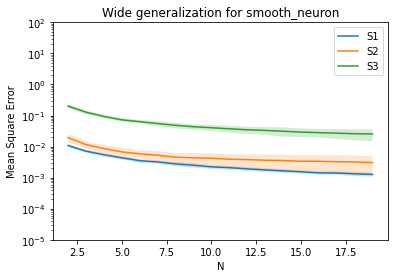

currently neuron
check for overfitting power of S1
lowest loss: 7.972102145092919e-11
performance of  S1  on  neuron
lamb = 0.0
[8.66942506 5.06700268 3.57265766 2.74255137 2.30477405 1.86980277
 1.66567918 1.56401629 1.3419924  1.23887374 1.13316765 1.0663505
 1.01715711 0.93518105 0.88659023 0.83246323 0.79293724 0.77108505]
[4.3262551  2.24644166 1.51136572 0.9242991  0.88384676 0.64503293
 0.59709131 0.55306166 0.4413489  0.41524566 0.37033962 0.35654493
 0.36144307 0.30391489 0.26573907 0.26962132 0.27931663 0.28104556]
check for overfitting power of S2
lowest loss: 4.375689968583174e-06


In [ ]:
compare_models(N_max, hidden_dim, iterations, batch_size, input_dim, smooth_neuron, narrow = False, log_plot = True,
              kernel_buff = True, squared = squared)
compare_models(N_max, hidden_dim, iterations, batch_size, input_dim, neuron, narrow = False, log_plot = True,
              kernel_buff = True, squared = squared)

compare_models(N_max, hidden_dim, iterations, batch_size, input_dim, smooth_neuron, narrow = True, log_plot = True,
              kernel_buff = True, squared = squared)
compare_models(N_max, hidden_dim, iterations, batch_size, input_dim, neuron, narrow = True, log_plot = True,
              kernel_buff = True, squared = squared)

In [ ]:
compare_models(N_max, hidden_dim, iterations, batch_size, input_dim, potential, narrow = False, log_plot = True)

In [ ]:
compare_models(N_max, hidden_dim, iterations, batch_size, input_dim, mean, narrow = False, log_plot = True,
              kernel_buff = True, squared = squared)
# compare_models(N_max, hidden_dim, iterations, batch_size, input_dim , mean, narrow = True, log_plot = True)

compare_models(N_max, hidden_dim, iterations, batch_size, input_dim, median, narrow = False, log_plot = True,
              kernel_buff = True, squared = squared)
# compare_models(N_max, hidden_dim, iterations, batch_size, input_dim , median, narrow = True, log_plot = True)

compare_models(N_max, hidden_dim, iterations, batch_size, input_dim, maximum, narrow = False, log_plot = True,
              kernel_buff = True, squared = squared)
# compare_models(N_max, hidden_dim, iterations, batch_size, input_dim , maximum, narrow = True, log_plot = True)

compare_models(N_max, hidden_dim, iterations, batch_size, input_dim, softmax, narrow = False, log_plot = True,
              kernel_buff = True, squared = squared)
# compare_models(N_max, hidden_dim, iterations, batch_size, input_dim , softmax, narrow = True, log_plot = True)

compare_models(N_max, hidden_dim, iterations, batch_size, input_dim, second, narrow = False, log_plot = True,
              kernel_buff = True, squared = squared)
# compare_models(N_max, hidden_dim, iterations, batch_size, input_dim , second, narrow = True, log_plot = True)

compare_models(N_max, hidden_dim, iterations, batch_size, input_dim, neuron, narrow = False, log_plot = True,
              kernel_buff = True, squared = squared)
# compare_models(N_max, hidden_dim, iterations, batch_size, input_dim , neuron, narrow = True, log_plot = True)

compare_models(N_max, hidden_dim, iterations, batch_size, input_dim, smooth_neuron, narrow = False, log_plot = True,
              kernel_buff = True, squared = squared)
# compare_models(N_max, hidden_dim, iterations, batch_size, input_dim , smooth_neuron, narrow = True, log_plot = True)




In [ ]:
compare_models(N_max, hidden_dim, iterations, batch_size, input_dim , neuron, narrow = True, log_plot = True, scaleup = True)
# compare_models(N_max, hidden_dim, iterations, batch_size, input_dim , smooth_neuron, narrow = True, log_plot = True, scaleup = True)

compare_models(N_max, hidden_dim, iterations, batch_size, input_dim , neuron, narrow = True, log_plot = True, scaleup = False)
# compare_models(N_max, hidden_dim, iterations, batch_size, input_dim , smooth_neuron, narrow = True, log_plot = True, scaleup = False)



In [ ]:
###############################################

In [ ]:
objective = neuron
narrow = False
bias_first = "neuron" in objective.__name__

kernel_buff = True
k = 10 if kernel_buff else 1

x, y = generate_data(N_max, batch_size, input_dim, objective, narrow, bias_first)

for i in range(5):
                
    model = Symmetric(input_dim, hidden_dim, hidden_dim, squared = squared)
    model.train()
    losses = train(model, x, y, iterations, lamb = 0.00, lr=0.0005)
    model.eval()
    print(losses[::int(iterations/10)])
    print("min", np.min(np.array(losses)))
    print("f1", generalization_error([4], 5000, input_dim, model, objective, narrow, bias_first))
                
    model = KNN(input_dim, k * hidden_dim, hidden_dim, squared = squared)
    model.train()
    losses = train(model, x, y, iterations, lamb = 0.00, lr=0.0005)
    model.eval()
    print(losses[::int(iterations/10)])
    print("min", np.min(np.array(losses)))
    print("f2", generalization_error([4], 5000, input_dim, model, objective, narrow, bias_first))
    
    model = KK(input_dim, k * hidden_dim, k * hidden_dim, squared = squared)
    model.train()
    losses = train(model, x, y, iterations, lamb = 0.00, lr=0.0005)
    model.eval()
    print(losses[::int(iterations/10)])
    print("min", np.min(np.array(losses)))
    print("f3", generalization_error([4], 5000, input_dim, model, objective, narrow, bias_first))

In [ ]:
#####################################

In [ ]:
def plot_from_memory(yrange, input_dim, objectives, narrows, scaleup):
    models = ["S1", "S2", "S3"]
    scaleup_str = "scaleup" if scaleup else ""
    N_list = np.arange(2, 4 + 16)
    
    for objective in objectives:
        for narrow in narrows:
            
            for model in models:
    
                save_str = model + "_" + objective + "_" + narrow + "_" + str(input_dim) + scaleup_str
                save_dir = "saved_data/"
        
                mean_error = np.load(save_dir + save_str + "_mean" + ".npy")
                std_error = np.load(save_dir + save_str + "_std" + ".npy")

                plt.semilogy(N_list, mean_error, label = model)
                plt.fill_between(N_list, mean_error - std_error, mean_error + std_error, alpha = 0.2)


            plt.legend()
            plt.ylim(yrange) 

            plt.xlabel("N")
            plt.ylabel("Mean Square Error")
            narrow_str = narrow
            plt.title(narrow_str + " generalization for " + objective)
            plt.savefig("plots_high_dim/" + objective + "_" + narrow_str + "_" + str(input_dim) + scaleup_str)
            plt.show()
            plt.close()

In [ ]:
local_input_dim = 20

# plot_from_memory([1e-4, 1e1], local_input_dim, ["mean", "median", "maximum", "softmax", "second"], ["Narrow", "Wide"], False)

plot_from_memory([1e-4, 1e1], local_input_dim, ["neuron"], ["Narrow", "Wide"], False)
plot_from_memory([1e-4, 1e1], local_input_dim, ["smooth_neuron"], ["Narrow", "Wide"], False)

plot_from_memory([1e-4, 1e1], local_input_dim, ["neuron"], ["Narrow"], True)
plot_from_memory([1e-4, 1e1], local_input_dim, ["neuron"], ["Narrow"], False)

plot_from_memory([1e-4, 1e1], local_input_dim, ["smooth_neuron"], ["Narrow"], True)
plot_from_memory([1e-4, 1e1], local_input_dim, ["smooth_neuron"], ["Narrow"], False)